In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# open file, preprocess data
data = pd.read_csv("wine.csv")
data = data.dropna()
X = data.drop("Class", axis=1)
y = data["Class"]
y = y - 1

feature_stds = X.std()

# add noise to features
X_noisy = X.copy()
for col in X.columns:
    noise = np.random.normal(loc=0.0, scale=feature_stds[col], size=len(X))
    X_noisy[col] += noise

X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.3, random_state=42, stratify=y)

# scale features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.from_numpy(X_train.to_numpy()).float()
y_train_tensor = torch.from_numpy(y_train.to_numpy()).long()

X_test_tensor = torch.from_numpy(X_test.to_numpy()).float()
y_test_tensor = torch.from_numpy(y_test.to_numpy()).long()

# Create Dataset and DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [20]:
# create MLP - use custom class
import torch
import torch.nn as nn
import torch.optim as optim

# 13 input features
# 3 outputs (3 possible classes)

# mlp class

class MLP(nn.Module):
    def __init__(self, input_size=13, hidden1=128, hidden2=64, output_size=3):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_size),
        )

    def forward(self, x):
        return self.model(x)

model = MLP()

# train model
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 200
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

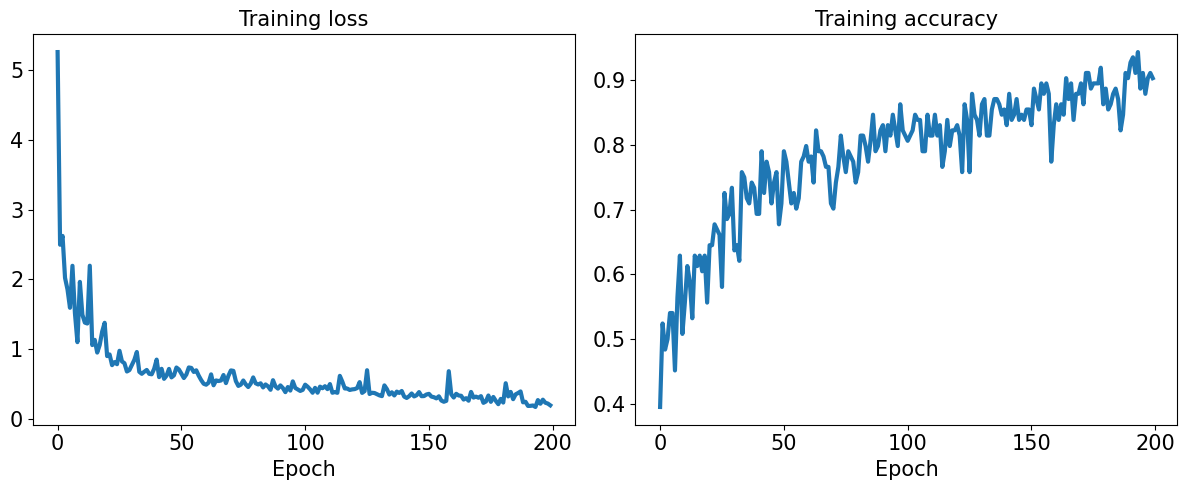

In [21]:
# plot loss function vs epochs and accuacy vs epochs

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

#plt.savefig('figures/12_09.pdf')
 
plt.show()